## Produce 2C GITT validation - Fig 3 (paper result)

### $ D_{\text{e},\text{EC}}^0 = 0, \, 1.5 \times 10^{-11}  \ \text{m}^2/\text{s} $ for 1M LiPF6 in EMC:EC 1:1 wt%

In [1]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2
import pybamm;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
import openpyxl; import traceback
import multiprocessing;import pandas as pd;
fs=11; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
fs=11; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [3]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(
   os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser(
   "~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'Validation_240313/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)
Save_Fig = True

In [4]:
# define parameter of double and single 
Para_dict_Same = {
   "Mesh list":[ [10,5,10,80,20], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[12e-3],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],
}

Para_dict_DD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,5e-12], # 
}
Para_dict_SD_ONLY = {
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",  },],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0], #  
   "Measured dLJP_dce":["dLJP_1_Specie_dc_e_np",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

2 1


In [5]:
Para_DD[0]["Lithium ion EC cross diffusivity [m2.s-1]"]

0

In [6]:
# import experimental GITT data from file
Target_input = "Input/"
GITT_data = pd.read_csv(
    BasicPath + Target_input + "2C_GITT_25deg_Niall.csv", comment="#", header=None
).to_numpy()
t_exp = GITT_data[:,0]/3600
I_exp = -GITT_data[:,3]/1000
V_exp = GITT_data[:,2]
#Q_exp = GITT_data[:,1]/1000
Q_exp = []
for i in range (len(t_exp)):
    Q_temp = np.trapz(I_exp[0:i],t_exp[0:i])
    Q_exp.append(Q_temp)

In [7]:
def Scan_GITT(index_i,Para_dd_i):
    print('Start Now! Scan %d.' % index_i)  
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)

    # model strictly follow experiment
    exp = pybamm.Experiment([(
        "Rest for 60 seconds (1 second period)", 
        "Discharge at 2C for 72 seconds or until 2.5V (0.1 second period)", 
        "Rest for 1 hour (1 second period)")] * 25,) 
    """ # adjust time perioid to allow quicker calculation
    exp = pybamm.Experiment([(
        "Rest for 5 seconds (1 second period)", 
        "Discharge at 2C for 72 seconds or until 2.5V (0.1 second period)", 
        "Rest for 10 seconds (1 second period)",
        "Rest for 3590 seconds (359 second period)",
        # move rest 1 minute to here so that don't need to shift time
        "Rest for 55 seconds (11 second period)", 
        )] * 25,)  """
    model = Add_var(para_used,model) # add extra variable to model
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = exp,
        parameter_values = para_used,
        #solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    return sol

In [8]:
# for DD first:
Index_DD = np.arange(1,len(Para_DD)+1).tolist()  
Index_SD = np.arange(1,len(Para_SD)+1).tolist()  
# scan: DD and SD respectively 
DD_Dis_All = []; SD_Dis_All = [];  
for i in range(len(Para_DD)):
    DD_Dis_All.append(  Scan_GITT(i+1, Para_DD[i])  )


Start Now! Scan 1.


CasADi - 2024-03-14 09:18:03 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]
At t = 0.00524739, , mxstep steps taken before reaching tout.
At t = 0.00372483, , mxstep steps taken before reaching tout.
At t = 0.00372483, , mxstep steps taken before reaching tout.
At t = 0.00294294, , mxstep steps taken before reaching tout.
At t = 0.00294294, , mxstep steps taken before reaching tout.


Start Now! Scan 2.


At t = 0.00525327, , mxstep steps taken before reaching tout.
At t = 0.00372954, , mxstep steps taken before reaching tout.
At t = 0.00372954, , mxstep steps taken before reaching tout.
At t = 0.00294643, , mxstep steps taken before reaching tout.
At t = 0.00294643, , mxstep steps taken before reaching tout.


In [9]:
for i in range(len(Para_SD)):
    SD_Dis_All.append(  Scan_GITT(i+1, Para_SD[i])  )  # """

Start Now! Scan 1.


At t = 0.00531406, , mxstep steps taken before reaching tout.
At t = 0.00377863, , mxstep steps taken before reaching tout.
At t = 0.00377863, , mxstep steps taken before reaching tout.
At t = 0.00298496, , mxstep steps taken before reaching tout.
At t = 0.00298496, , mxstep steps taken before reaching tout.


'  \n# Plot Single\nfor i in range(1):\n    D_e_EC_cross = Para_SD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]\n    Plot_Comp_GITT_Overall(\n        SD_Dis_All[i],Save_Fig,\n        fig_name=f"Fig__Validation__GITT_2C_discharge_298K__Single_D_e_EC_cross={D_e_EC_cross}") '

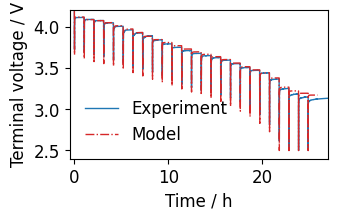

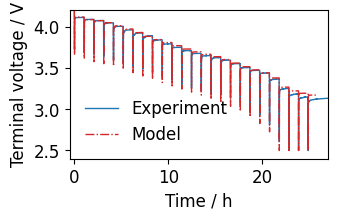

In [10]:
# Fig.1 - (a) Overall:
def Plot_Comp_GITT_Overall(sol,Save_Fig,fig_name):
    # Plot setting
    font = {'family' : 'DejaVu Sans', 'size' : 12}
    mpl.rc('font', **font)
    lw=1;
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e']
    # Date pre-processing
    t_exp_hours = t_exp-t_exp[0];
    # sol = DD_Dis_All[0]
    t_seconds = sol["Time [s]"].entries
    t_sim_start = sol.cycles[0].steps[0]["Time [s]"].entries[-1]  # shift
    t_hours = (t_seconds - t_sim_start) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries

    fig, ax = plt.subplots(figsize=(9/2.54,6/2.54),tight_layout=True)
    ax.plot(
        t_exp_hours,V_exp, color=Colors[0],
        linewidth=lw,
        linestyle='-',label='Experiment')
    ax.plot(
        t_hours,V,color=Colors[2],linewidth=lw,    
        linestyle='-.',label='Model')

    ax.set_xlabel('Time / h')
    ax.set_ylabel('Terminal voltage / V')
    plt.xlim(-0.5,27)
    plt.ylim(2.4,4.21)
    #ax.set_title('25x1C pulses at 298K, comparison')
    ax.legend(loc='best',frameon=False)
    if Save_Fig:
        plt.savefig(BasicPath + Target + f'{fig_name}.png',dpi=600)
        plt.savefig(BasicPath + Target + f'{fig_name}.svg')  
    return 

for i in range(len(Para_DD)):
    D_e_EC_cross = Para_DD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    Plot_Comp_GITT_Overall(
        DD_Dis_All[i],Save_Fig,
       fig_name=f"Fig__Validation__GITT_2C_discharge_298K__Double_D_e_EC_cross={D_e_EC_cross}") 
"""  
# Plot Single
for i in range(1):
    D_e_EC_cross = Para_SD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    Plot_Comp_GITT_Overall(
        SD_Dis_All[i],Save_Fig,
        fig_name=f"Fig__Validation__GITT_2C_discharge_298K__Single_D_e_EC_cross={D_e_EC_cross}") """

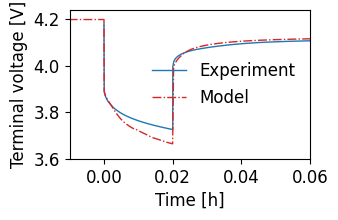

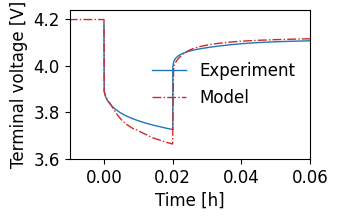

In [11]:
# zoom in:
lw = 1
def Plot_compare_zoom ( sol, Xlim , Ylim):
    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
    t_exp_hours = t_exp-t_exp[0];
    t_seconds = sol["Time [s]"].entries
    # shift the modelling time to t=0 to be first discharge
    t_sim_start = sol.cycles[0].steps[0]["Time [s]"].entries[-1] 
    t_hours = (t_seconds - t_sim_start) / 3600
    I = sol["Current [A]"].entries
    Q = sol["Discharge capacity [A.h]"].entries
    V = sol["Terminal voltage [V]"].entries

    fig, ax = plt.subplots(figsize=(9/2.54,6/2.54),tight_layout=True)
    ax.plot(
        t_exp_hours,V_exp, color=Colors[0],
        linewidth=lw,
        linestyle='-',label='Experiment')
    ax.plot(
        t_hours,V,color=Colors[2],linewidth=lw,    
        linestyle='-.',label='Model')

    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Terminal voltage [V]')
    # plt.xlim(-0.5,27)
    # plt.ylim(2.4,4.21)
    plt.xlim(Xlim)
    plt.ylim(Ylim)
    #ax.set_title('25x1C pulses at 298K, comparison')
    ax.legend(loc='best',frameon=False)
    return 
Xlim=(-0.01,0.06) ; Ylim = (3.6,4.24)
""" for i in range(1):
    Plot_compare_zoom ( SD_Dis_All[i], Xlim , Ylim) """
for i in range(len(DD_Dis_All)):
    Plot_compare_zoom ( DD_Dis_All[i], Xlim , Ylim)


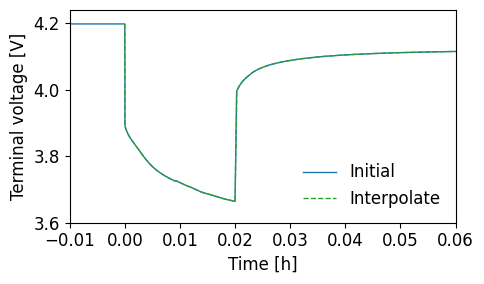

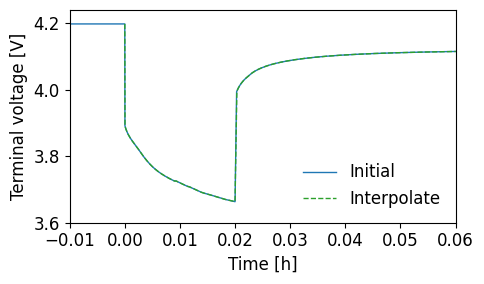

In [12]:
# to calculate RMSE 
font = {'family' : 'DejaVu Sans', 'size' : 12}
mpl.rc('font', **font)
lw=1;
Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
# interpolate expeirment data to align with simulation
def calculate_mpe_mape(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError("The length of actual and predicted lists must be the same.")
    if 0 in actual:
        raise ValueError("Actual values contain zero, which will lead to division by zero in MAPE calculation.")

    mpe_sum = 0
    mape_sum = 0
    n = len(actual)

    for a, p in zip(actual, predicted):
        mpe_sum += (a - p) / a
        mape_sum += abs((a - p) / a)

    mpe = (mpe_sum / n) * 100
    mape = (mape_sum / n) * 100

    return mpe, mape

def Inter_Plot(sol,Save_Fig,fig_name):
    t_exp_hours = t_exp-t_exp[0]
    t_seconds = sol["Time [s]"].entries
    t_sim_start = sol.cycles[0].steps[0]["Time [s]"].entries[-1]  # shift
    t_hours = (t_seconds - t_sim_start) / 3600
    V = sol["Terminal voltage [V]"].entries
    V_exp_int1 = np.interp(t_exp_hours,t_hours,V) 

    fig, ax = plt.subplots(figsize=(5,3),tight_layout=True)
    ax.plot(
        t_hours,V, color=Colors[0],
        linewidth=lw,
        linestyle='-',label='Initial')
    ax.plot(
        t_exp_hours,V_exp_int1, color=Colors[1],
        linewidth=lw,
        linestyle='--',label='Interpolate')
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Terminal voltage [V]')
    Xlim=(-0.01,0.06) ; Ylim = (3.6,4.24)
    plt.xlim(Xlim)
    plt.ylim(Ylim)
    
    ax.legend(loc='best',frameon=False)
    if Save_Fig:
        plt.savefig(BasicPath + Target + f'{fig_name}.png',dpi=600)
        plt.savefig(BasicPath + Target + f'{fig_name}.svg')  
    rmse = np.sqrt(np.mean((V_exp_int1-V_exp)**2))
    mpe, mape = calculate_mpe_mape(V_exp, V_exp_int1)
    return t_hours,V_exp_int1,rmse,mpe, mape
SD_V_exp_int1_List = []; SD_RMSE_List = []; SD_MPE_List = []; SD_MAPE_List = []; 
DD_V_exp_int1_List = []; DD_RMSE_List = []; DD_MPE_List = []; DD_MAPE_List = []; 
""" for i in range(1):
    t_hours,V_exp_int1,rmse,mpe, mape = Inter_Plot(SD_Dis_All[i],Save_Fig,"fig_name")
    SD_V_exp_int1_List.append(V_exp_int1)
    SD_RMSE_List.append(rmse)
    SD_MPE_List.append(mpe)
    SD_MAPE_List.append(mape) """
for i in range(len(DD_Dis_All)):    
    t_hours,V_exp_int1,rmse,mpe, mape = Inter_Plot(DD_Dis_All[i],Save_Fig,"fig_name")
    DD_V_exp_int1_List.append(V_exp_int1)
    DD_RMSE_List.append(rmse)
    DD_MPE_List.append(mpe)
    DD_MAPE_List.append(mape)

In [13]:
print("rmse")
print(DD_RMSE_List)
print(SD_RMSE_List)
print("mpe")
print(DD_MPE_List)
print(SD_MPE_List)
print("mape")
print(DD_MAPE_List)
print(SD_MAPE_List)

rmse
[0.04160853222685758, 0.0418917953851461]
[]
mpe
[-0.14321623534182978, -0.14181121903853935]
[]
mape
[0.697486679674742, 0.7011238403018931]
[]


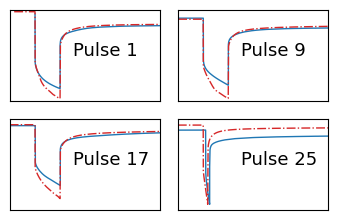

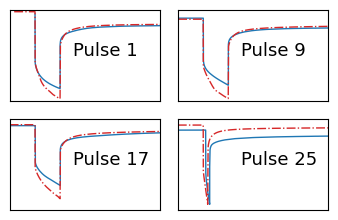

In [14]:
# Fig.1 - (b) Pulse [1,9,17,25]:
def Plot_GITT_4Pulse(sol,Pulse,Ylim,Save_Fig,fig_name):
    fs=12;   lw=1
    font = {'family' : 'DejaVu Sans', 'size' : fs}

    Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
    fig, axs = plt.subplots(2,2,figsize=(9/2.54,6/2.54),tight_layout=True)
    k=0
    for i in range(2):
        for j in range(2):
            axs[i,j].plot(
                t_exp-t_exp[0],V_exp, color=Colors[0],
                linewidth=lw,
                linestyle='-',label='Experiment')
            t_seconds = sol["Time [s]"].entries
            V = sol["Terminal voltage [V]"].entries
            t_sim_start = sol.cycles[0].steps[0]["Time [s]"].entries[-1] # shift
            t_hours = (t_seconds - t_sim_start) / 3600
            axs[i,j].plot(
                t_hours,V,color=Colors[2],linewidth=lw,    
                linestyle='-.',label='Model')
            t_s=sol.cycles[Pulse[k]]["Time [h]"].entries[0]

            axs[i,j].set_xlim(t_s-0.02,t_s+0.1)
            axs[i,j].set_ylim(Ylim[k])# 
            axs[i,j].text(
                t_s+0.03, np.mean(Ylim[k][:]),
                f'Pulse {Pulse[k]+1}',  fontsize=fs+1) 
            axs[i,j].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            k += 1
    if Save_Fig:
        plt.savefig(BasicPath + Target + f'{fig_name}.png',dpi=600)
        plt.savefig(BasicPath + Target + f'{fig_name}.svg')  
    return 

Pulse =  [0,8,16,24]
Ylim = [(3.65,4.21),(3.35,3.95),(2.95,3.65),(2.45,3.25),]
""" for i in range(1):
    D_e_EC_cross = Para_SD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    Plot_GITT_4Pulse(
        SD_Dis_All[i],Pulse,Ylim,
        Save_Fig,fig_name="Fig_Zoom_GITT_2C_4_Pulse_Single") """
for i in range(len(DD_Dis_All)):
    D_e_EC_cross = Para_DD[i]["Lithium ion EC cross diffusivity [m2.s-1]"]
    Plot_GITT_4Pulse(
        DD_Dis_All[i],Pulse,Ylim,
        Save_Fig,fig_name=f"Fig_Zoom_GITT_2C_4_Pulse_Double_D_e_EC_cross={D_e_EC_cross}")

In [15]:
t_hours

array([-1.66666667e-02, -1.63888889e-02, -1.61111111e-02, ...,
        2.58563362e+01,  2.58566140e+01,  2.58568918e+01])

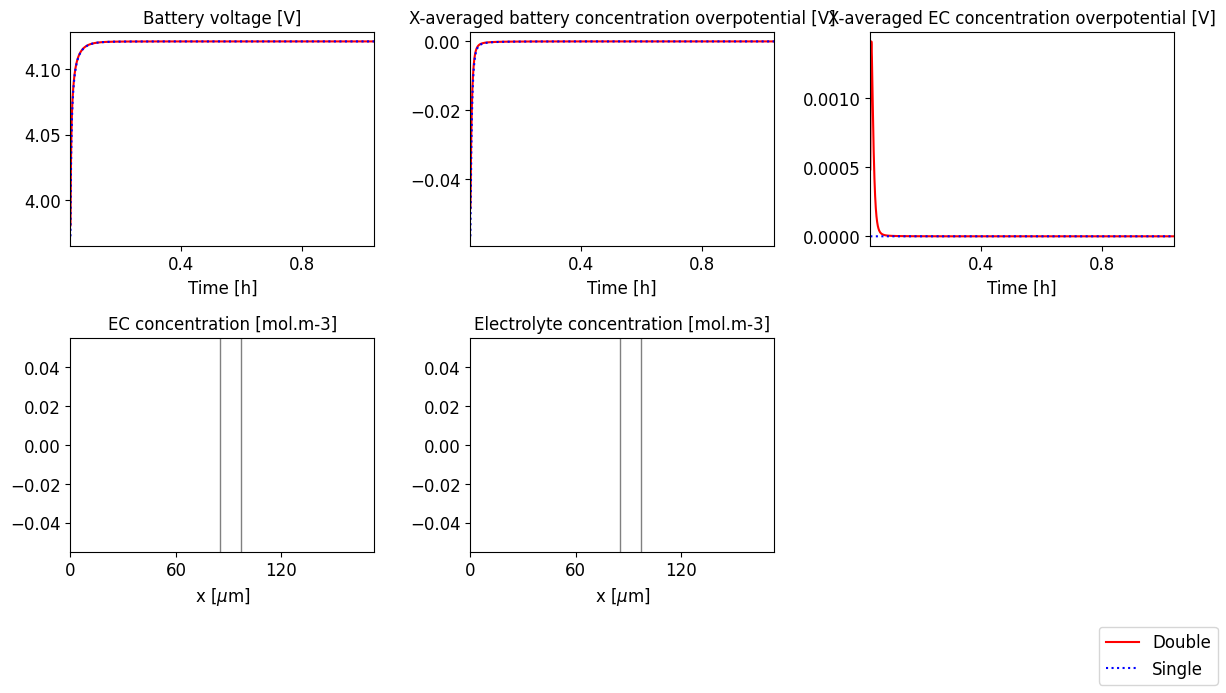

In [16]:
label = ["Double","Single"] 
var = [
    "Battery voltage [V]",
    #"X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    #"X-averaged battery electrolyte ohmic losses [V]",
    #"X-averaged battery solid phase ohmic losses [V]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
]
quick_plot = pybamm.QuickPlot(
    [
        DD_Dis_All[0].cycles[0].steps[2],
        SD_Dis_All[0].cycles[0].steps[2],
        ], var,label,variable_limits='tight',
    time_unit='hours',n_rows=2) #figsize = (18,12),
#quick_plot.dynamic_plot()
quick_plot.plot(0.02)